## Imports

In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
import xgboost as xgb

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [5]:
def read_data(filename):
    df = pd.read_parquet(filename)
    
    categories_columns = ['PULocationID', 'DOLocationID']
    df[categories_columns] = df[categories_columns].astype('str')
    
    df['duration'] = df['lpep_dropoff_datetime'] -  df['lpep_pickup_datetime']
    
    df['duration'] = (df['duration'].dt.seconds /60).astype('float64').round(4) # duration in minutes
    
    # just o get the same result --> but is probably wrong do this in validation data
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    return df

In [6]:
def select_data(data):
    
    data['PU_DO'] = data['PULocationID'] + '_' +data['DOLocationID']
    
    categories_columns = ['PU_DO']
    #categories_columns = ['PULocationID', 'DOLocationID']
    numerical_columns = ['trip_distance']
    
    dict_data = data[categories_columns + numerical_columns].to_dict(orient='records')
    
    return dict_data

## Train Data

In [7]:
train_path = 'datasets/green_tripdata_2021-01.parquet'
df_train = read_data(train_path)

#df_train = df_train.loc[df_train['duration'].between(1,60)]

y_train = df_train['duration']

dict_train = select_data(df_train)
dv = DictVectorizer()
x_train = dv.fit_transform(dict_train)

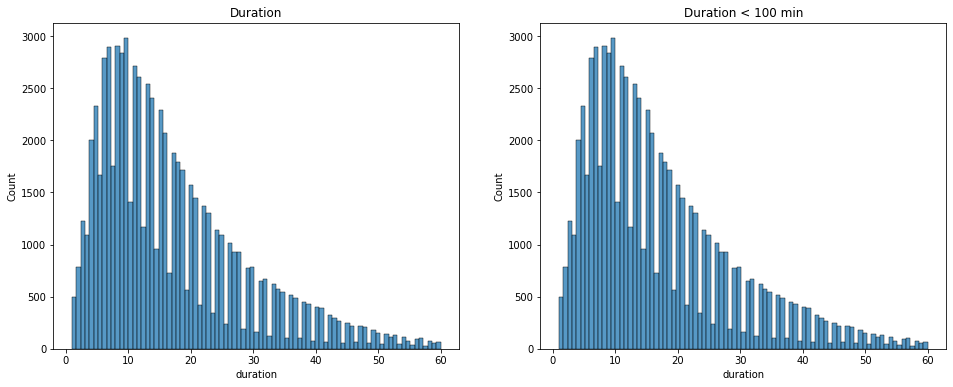

In [9]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(df_train['duration']).set_title('Duration')
plt.subplot(1,2,2)
sns.histplot(df_train.loc[df_train['duration']<100, 'duration']).set_title('Duration < 100 min');

## Validation Data

In [10]:
val_path = 'datasets/green_tripdata_2021-02.parquet'
df_validation = read_data(val_path)

y_validation = df_validation['duration']

dict_validation = select_data(df_validation)

x_validation = dv.transform(dict_validation)

## Train and Evaluate Model

### LR MODEL

In [11]:
# define model
lr = LinearRegression()
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

rmse = mean_squared_error(y_predict, y_validation, squared=False)
print(f'Mean Squared Errror: {rmse}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 7.758715071950948
Mean Absolute Percentage Error: 0.4174608942923692


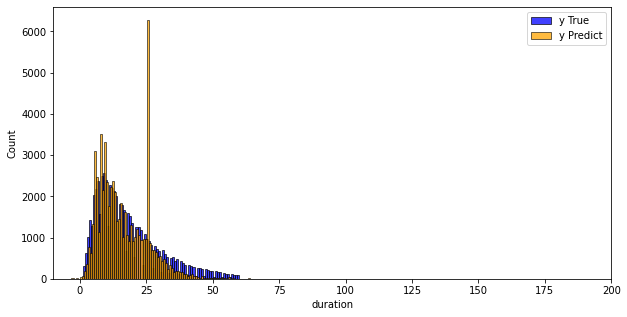

In [12]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Lasso

In [27]:
with mlflow.start_run(): 

    mlflow.set_tag("developer", "miguel")

    mlflow.log_param("train-data-path", train_path)
    mlflow.log_param("validation-data-path", val_path)

    alpha = 0.01

    mlflow.log_param("alpha", alpha)

    # define model
    lr = Lasso(alpha)
    # train model
    lr.fit(x_train, y_train)
    # predict on validation
    y_predict = lr.predict(x_validation)

    rmse = mean_squared_error(y_predict, y_validation, squared=False)

    mlflow.log_metric("rmse", rmse)
    print(f'Mean Squared Errror: {rmse}')

    print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

Mean Squared Errror: 11.16727583511989
Mean Absolute Percentage Error: 0.4807476874827497


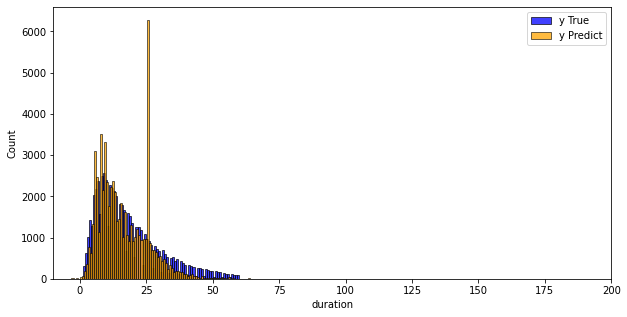

In [13]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Ridge

In [14]:
# define model
lr = Ridge(alpha=0.1)
# train model
lr.fit(x_train, y_train)
# predict on validation
y_predict = lr.predict(x_validation)

rmse = mean_squared_error(y_predict, y_validation, squared=False)
print(f'Mean Squared Errror: {rmse}')

print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_predict, y_validation)}')

Mean Squared Errror: 11.3425690614976
Mean Absolute Percentage Error: 0.6155785329763492


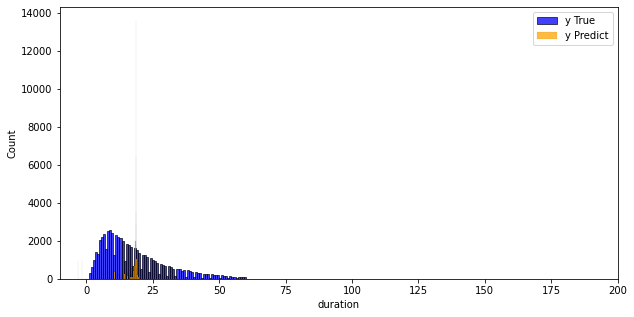

In [15]:
plt.figure(figsize=(10,5))
ax= sns.histplot(y_validation, label='y True', color='blue')
sns.histplot(y_predict, label='y Predict', color='orange', ax=ax)

ax.set_xlim(-10, 200)
plt.legend();

## Save Model

In [39]:
with open('models/lin_reg.bin', 'wb') as file:
    pickle.dump((dv, lr),file) # for now linear regression

## XGBoost

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(x_train, label=y_train)
valid = xgb.DMatrix(x_validation, label=y_validation)

In [18]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_validation, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [19]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[19:31:46] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.   
[0]	validation-rmse:6.86043                                                                                              
[1]	validation-rmse:6.67665                                                                                              
[2]	validation-rmse:6.66012                                                                                              
[3]	validation-rmse:6.64637                                                                                              
[4]	validation-rmse:6.64061                                                                                              
[5]	validation-rmse:6.62631                                                                                              
[6]	validation-rmse:6.62293                                                                                              
[7]	validation-rmse:6.61

[38]	validation-rmse:6.65702                                                                                             
[39]	validation-rmse:6.65662                                                                                             
[40]	validation-rmse:6.65644                                                                                             
[41]	validation-rmse:6.65661                                                                                             
[42]	validation-rmse:6.65654                                                                                             
[43]	validation-rmse:6.65665                                                                                             
[44]	validation-rmse:6.65672                                                                                             
[45]	validation-rmse:6.65612                                                                                             
[46]	validation-rmse:6.6

[57]	validation-rmse:6.50391                                                                                             
[58]	validation-rmse:6.50257                                                                                             
[59]	validation-rmse:6.50164                                                                                             
[60]	validation-rmse:6.50107                                                                                             
[61]	validation-rmse:6.49986                                                                                             
[62]	validation-rmse:6.49939                                                                                             
[63]	validation-rmse:6.49950                                                                                             
[64]	validation-rmse:6.49788                                                                                             
[65]	validation-rmse:6.4

[191]	validation-rmse:6.46405                                                                                            
[192]	validation-rmse:6.46392                                                                                            
[193]	validation-rmse:6.46409                                                                                            
[194]	validation-rmse:6.46386                                                                                            
[195]	validation-rmse:6.46386                                                                                            
[196]	validation-rmse:6.46435                                                                                            
[197]	validation-rmse:6.46513                                                                                            
[198]	validation-rmse:6.46467                                                                                            
[199]	validation-rmse:6.

[37]	validation-rmse:7.34337                                                                                             
[38]	validation-rmse:7.29410                                                                                             
[39]	validation-rmse:7.24900                                                                                             
[40]	validation-rmse:7.20798                                                                                             
[41]	validation-rmse:7.17009                                                                                             
[42]	validation-rmse:7.13475                                                                                             
[43]	validation-rmse:7.10297                                                                                             
[44]	validation-rmse:7.07303                                                                                             
[45]	validation-rmse:7.0

[171]	validation-rmse:6.65929                                                                                            
[172]	validation-rmse:6.65916                                                                                            
[173]	validation-rmse:6.65892                                                                                            
[174]	validation-rmse:6.65894                                                                                            
[175]	validation-rmse:6.65881                                                                                            
[176]	validation-rmse:6.65871                                                                                            
[177]	validation-rmse:6.65860                                                                                            
[178]	validation-rmse:6.65856                                                                                            
[179]	validation-rmse:6.

[305]	validation-rmse:6.65153                                                                                            
[306]	validation-rmse:6.65155                                                                                            
[307]	validation-rmse:6.65157                                                                                            
[308]	validation-rmse:6.65146                                                                                            
[309]	validation-rmse:6.65148                                                                                            
[310]	validation-rmse:6.65149                                                                                            
[311]	validation-rmse:6.65147                                                                                            
[312]	validation-rmse:6.65148                                                                                            
[313]	validation-rmse:6.

[439]	validation-rmse:6.64603                                                                                            
[440]	validation-rmse:6.64593                                                                                            
[441]	validation-rmse:6.64595                                                                                            
[442]	validation-rmse:6.64592                                                                                            
[443]	validation-rmse:6.64584                                                                                            
[444]	validation-rmse:6.64586                                                                                            
[445]	validation-rmse:6.64580                                                                                            
[446]	validation-rmse:6.64578                                                                                            
[447]	validation-rmse:6.

[573]	validation-rmse:6.64266                                                                                            
[574]	validation-rmse:6.64280                                                                                            
[575]	validation-rmse:6.64280                                                                                            
[576]	validation-rmse:6.64279                                                                                            
[577]	validation-rmse:6.64275                                                                                            
[578]	validation-rmse:6.64271                                                                                            
[579]	validation-rmse:6.64263                                                                                            
[580]	validation-rmse:6.64259                                                                                            
[581]	validation-rmse:6.

[70]	validation-rmse:6.53341                                                                                             
[71]	validation-rmse:6.53338                                                                                             
[72]	validation-rmse:6.53269                                                                                             
[73]	validation-rmse:6.53273                                                                                             
[74]	validation-rmse:6.53244                                                                                             
[75]	validation-rmse:6.53186                                                                                             
[76]	validation-rmse:6.53163                                                                                             
[77]	validation-rmse:6.53200                                                                                             
[78]	validation-rmse:6.5

[49]	validation-rmse:6.42542                                                                                             
[50]	validation-rmse:6.42415                                                                                             
[51]	validation-rmse:6.42249                                                                                             
[52]	validation-rmse:6.42155                                                                                             
[53]	validation-rmse:6.42102                                                                                             
[54]	validation-rmse:6.42019                                                                                             
[55]	validation-rmse:6.41945                                                                                             
[56]	validation-rmse:6.41879                                                                                             
[57]	validation-rmse:6.4

[183]	validation-rmse:6.37928                                                                                            
[184]	validation-rmse:6.37927                                                                                            
[185]	validation-rmse:6.37881                                                                                            
[186]	validation-rmse:6.37843                                                                                            
[187]	validation-rmse:6.37844                                                                                            
[188]	validation-rmse:6.37865                                                                                            
[189]	validation-rmse:6.37801                                                                                            
[190]	validation-rmse:6.37792                                                                                            
[191]	validation-rmse:6.

[18]	validation-rmse:6.97826                                                                                             
[19]	validation-rmse:6.92902                                                                                             
[20]	validation-rmse:6.88935                                                                                             
[21]	validation-rmse:6.85606                                                                                             
[22]	validation-rmse:6.82876                                                                                             
[23]	validation-rmse:6.80482                                                                                             
[24]	validation-rmse:6.78595                                                                                             
[25]	validation-rmse:6.77148                                                                                             
[26]	validation-rmse:6.7

[152]	validation-rmse:6.61827                                                                                            
[153]	validation-rmse:6.61812                                                                                            
[154]	validation-rmse:6.61772                                                                                            
[155]	validation-rmse:6.61728                                                                                            
[156]	validation-rmse:6.61687                                                                                            
[157]	validation-rmse:6.61661                                                                                            
[158]	validation-rmse:6.61622                                                                                            
[159]	validation-rmse:6.61600                                                                                            
[160]	validation-rmse:6.

[286]	validation-rmse:6.58666                                                                                            
[287]	validation-rmse:6.58629                                                                                            
[288]	validation-rmse:6.58609                                                                                            
[289]	validation-rmse:6.58585                                                                                            
[290]	validation-rmse:6.58518                                                                                            
[291]	validation-rmse:6.58506                                                                                            
[292]	validation-rmse:6.58488                                                                                            
[293]	validation-rmse:6.58464                                                                                            
[294]	validation-rmse:6.

[420]	validation-rmse:6.56910                                                                                            
[421]	validation-rmse:6.56902                                                                                            
[422]	validation-rmse:6.56886                                                                                            
[423]	validation-rmse:6.56872                                                                                            
[424]	validation-rmse:6.56867                                                                                            
[425]	validation-rmse:6.56852                                                                                            
[426]	validation-rmse:6.56835                                                                                            
[427]	validation-rmse:6.56826                                                                                            
[428]	validation-rmse:6.

[554]	validation-rmse:6.55834                                                                                            
[555]	validation-rmse:6.55825                                                                                            
[556]	validation-rmse:6.55817                                                                                            
[557]	validation-rmse:6.55817                                                                                            
[558]	validation-rmse:6.55799                                                                                            
[559]	validation-rmse:6.55798                                                                                            
[560]	validation-rmse:6.55797                                                                                            
[561]	validation-rmse:6.55787                                                                                            
[562]	validation-rmse:6.

[688]	validation-rmse:6.55042                                                                                            
[689]	validation-rmse:6.55036                                                                                            
[690]	validation-rmse:6.55037                                                                                            
[691]	validation-rmse:6.55053                                                                                            
[692]	validation-rmse:6.55051                                                                                            
[693]	validation-rmse:6.55048                                                                                            
[694]	validation-rmse:6.55041                                                                                            
[695]	validation-rmse:6.55036                                                                                            
[696]	validation-rmse:6.

[822]	validation-rmse:6.54378                                                                                            
[823]	validation-rmse:6.54379                                                                                            
[824]	validation-rmse:6.54379                                                                                            
[825]	validation-rmse:6.54373                                                                                            
[826]	validation-rmse:6.54375                                                                                            
[827]	validation-rmse:6.54374                                                                                            
[828]	validation-rmse:6.54368                                                                                            
[829]	validation-rmse:6.54354                                                                                            
[830]	validation-rmse:6.

[956]	validation-rmse:6.54033                                                                                            
[957]	validation-rmse:6.54037                                                                                            
[958]	validation-rmse:6.54029                                                                                            
[959]	validation-rmse:6.54025                                                                                            
[960]	validation-rmse:6.54026                                                                                            
[961]	validation-rmse:6.54020                                                                                            
[962]	validation-rmse:6.54018                                                                                            
[963]	validation-rmse:6.54030                                                                                            
[964]	validation-rmse:6.

[89]	validation-rmse:6.66972                                                                                             
[90]	validation-rmse:6.66926                                                                                             
[91]	validation-rmse:6.66876                                                                                             
[92]	validation-rmse:6.66841                                                                                             
[93]	validation-rmse:6.66784                                                                                             
[94]	validation-rmse:6.66696                                                                                             
[95]	validation-rmse:6.66645                                                                                             
[96]	validation-rmse:6.66622                                                                                             
[97]	validation-rmse:6.6

[223]	validation-rmse:6.62213                                                                                            
[224]	validation-rmse:6.62183                                                                                            
[225]	validation-rmse:6.62157                                                                                            
[226]	validation-rmse:6.62143                                                                                            
[227]	validation-rmse:6.62124                                                                                            
[228]	validation-rmse:6.62074                                                                                            
[229]	validation-rmse:6.61968                                                                                            
[230]	validation-rmse:6.61943                                                                                            
[231]	validation-rmse:6.

[357]	validation-rmse:6.59532                                                                                            
[358]	validation-rmse:6.59523                                                                                            
[359]	validation-rmse:6.59509                                                                                            
[360]	validation-rmse:6.59506                                                                                            
[361]	validation-rmse:6.59491                                                                                            
[362]	validation-rmse:6.59482                                                                                            
[363]	validation-rmse:6.59470                                                                                            
[364]	validation-rmse:6.59452                                                                                            
[365]	validation-rmse:6.

[491]	validation-rmse:6.57895                                                                                            
[492]	validation-rmse:6.57886                                                                                            
[493]	validation-rmse:6.57879                                                                                            
[494]	validation-rmse:6.57873                                                                                            
[495]	validation-rmse:6.57870                                                                                            
[496]	validation-rmse:6.57859                                                                                            
[497]	validation-rmse:6.57848                                                                                            
[498]	validation-rmse:6.57842                                                                                            
[499]	validation-rmse:6.

[625]	validation-rmse:6.56803                                                                                            
[626]	validation-rmse:6.56794                                                                                            
[627]	validation-rmse:6.56794                                                                                            
[628]	validation-rmse:6.56784                                                                                            
[629]	validation-rmse:6.56778                                                                                            
[630]	validation-rmse:6.56766                                                                                            
[631]	validation-rmse:6.56759                                                                                            
[632]	validation-rmse:6.56750                                                                                            
[633]	validation-rmse:6.

[759]	validation-rmse:6.56008                                                                                            
[760]	validation-rmse:6.56004                                                                                            
[761]	validation-rmse:6.55998                                                                                            
[762]	validation-rmse:6.55994                                                                                            
[763]	validation-rmse:6.55990                                                                                            
[764]	validation-rmse:6.55985                                                                                            
[765]	validation-rmse:6.55981                                                                                            
[766]	validation-rmse:6.55982                                                                                            
[767]	validation-rmse:6.

[893]	validation-rmse:6.55398                                                                                            
[894]	validation-rmse:6.55394                                                                                            
[895]	validation-rmse:6.55392                                                                                            
[896]	validation-rmse:6.55385                                                                                            
[897]	validation-rmse:6.55383                                                                                            
[898]	validation-rmse:6.55379                                                                                            
[899]	validation-rmse:6.55368                                                                                            
[900]	validation-rmse:6.55363                                                                                            
[901]	validation-rmse:6.

[26]	validation-rmse:6.51798                                                                                             
[27]	validation-rmse:6.51314                                                                                             
[28]	validation-rmse:6.50959                                                                                             
[29]	validation-rmse:6.50725                                                                                             
[30]	validation-rmse:6.50430                                                                                             
[31]	validation-rmse:6.50055                                                                                             
[32]	validation-rmse:6.49787                                                                                             
[33]	validation-rmse:6.49555                                                                                             
[34]	validation-rmse:6.4

[160]	validation-rmse:6.38708                                                                                            
[161]	validation-rmse:6.38661                                                                                            
[162]	validation-rmse:6.38554                                                                                            
[163]	validation-rmse:6.38511                                                                                            
[164]	validation-rmse:6.38481                                                                                            
[165]	validation-rmse:6.38456                                                                                            
[166]	validation-rmse:6.38398                                                                                            
[167]	validation-rmse:6.38341                                                                                            
[168]	validation-rmse:6.

[294]	validation-rmse:6.34676                                                                                            
[295]	validation-rmse:6.34686                                                                                            
[296]	validation-rmse:6.34673                                                                                            
[297]	validation-rmse:6.34631                                                                                            
[298]	validation-rmse:6.34642                                                                                            
[299]	validation-rmse:6.34629                                                                                            
[300]	validation-rmse:6.34630                                                                                            
[301]	validation-rmse:6.34617                                                                                            
[302]	validation-rmse:6.

[428]	validation-rmse:6.33188                                                                                            
[429]	validation-rmse:6.33218                                                                                            
[430]	validation-rmse:6.33194                                                                                            
[431]	validation-rmse:6.33193                                                                                            
[432]	validation-rmse:6.33195                                                                                            
[433]	validation-rmse:6.33174                                                                                            
[434]	validation-rmse:6.33164                                                                                            
[435]	validation-rmse:6.33166                                                                                            
[436]	validation-rmse:6.

[562]	validation-rmse:6.32448                                                                                            
[563]	validation-rmse:6.32448                                                                                            
[564]	validation-rmse:6.32447                                                                                            
[565]	validation-rmse:6.32422                                                                                            
[566]	validation-rmse:6.32420                                                                                            
[567]	validation-rmse:6.32414                                                                                            
[568]	validation-rmse:6.32404                                                                                            
[569]	validation-rmse:6.32347                                                                                            
[570]	validation-rmse:6.

[49]	validation-rmse:6.56273                                                                                             
[50]	validation-rmse:6.55996                                                                                             
[51]	validation-rmse:6.55805                                                                                             
[52]	validation-rmse:6.55599                                                                                             
[53]	validation-rmse:6.55393                                                                                             
[54]	validation-rmse:6.55182                                                                                             
[55]	validation-rmse:6.55009                                                                                             
[56]	validation-rmse:6.54829                                                                                             
[57]	validation-rmse:6.5

[183]	validation-rmse:6.47862                                                                                            
[184]	validation-rmse:6.47814                                                                                            
[185]	validation-rmse:6.47787                                                                                            
[186]	validation-rmse:6.47746                                                                                            
[187]	validation-rmse:6.47693                                                                                            
[188]	validation-rmse:6.47679                                                                                            
[189]	validation-rmse:6.47682                                                                                            
[190]	validation-rmse:6.47675                                                                                            
[191]	validation-rmse:6.

[317]	validation-rmse:6.45317                                                                                            
[318]	validation-rmse:6.45305                                                                                            
[319]	validation-rmse:6.45299                                                                                            
[320]	validation-rmse:6.45278                                                                                            
[321]	validation-rmse:6.45288                                                                                            
[322]	validation-rmse:6.45255                                                                                            
[323]	validation-rmse:6.45262                                                                                            
[324]	validation-rmse:6.45245                                                                                            
[325]	validation-rmse:6.

[451]	validation-rmse:6.44109                                                                                            
[452]	validation-rmse:6.44073                                                                                            
[453]	validation-rmse:6.44065                                                                                            
[454]	validation-rmse:6.44063                                                                                            
[455]	validation-rmse:6.44046                                                                                            
[456]	validation-rmse:6.44031                                                                                            
[457]	validation-rmse:6.44054                                                                                            
[458]	validation-rmse:6.44039                                                                                            
[459]	validation-rmse:6.

[585]	validation-rmse:6.43519                                                                                            
[586]	validation-rmse:6.43499                                                                                            
[587]	validation-rmse:6.43511                                                                                            
[588]	validation-rmse:6.43506                                                                                            
[589]	validation-rmse:6.43502                                                                                            
[590]	validation-rmse:6.43505                                                                                            
[591]	validation-rmse:6.43499                                                                                            
[592]	validation-rmse:6.43494                                                                                            
[593]	validation-rmse:6.

[60]	validation-rmse:6.64270                                                                                             
[61]	validation-rmse:6.63709                                                                                             
[62]	validation-rmse:6.63294                                                                                             
[63]	validation-rmse:6.62885                                                                                             
[64]	validation-rmse:6.62405                                                                                             
[65]	validation-rmse:6.62059                                                                                             
[66]	validation-rmse:6.61682                                                                                             
[67]	validation-rmse:6.61366                                                                                             
[68]	validation-rmse:6.6

[194]	validation-rmse:6.53474                                                                                            
[195]	validation-rmse:6.53466                                                                                            
[196]	validation-rmse:6.53446                                                                                            
[197]	validation-rmse:6.53429                                                                                            
[198]	validation-rmse:6.53406                                                                                            
[199]	validation-rmse:6.53371                                                                                            
[200]	validation-rmse:6.53355                                                                                            
[201]	validation-rmse:6.53318                                                                                            
[202]	validation-rmse:6.

[328]	validation-rmse:6.51565                                                                                            
[329]	validation-rmse:6.51549                                                                                            
[330]	validation-rmse:6.51537                                                                                            
[331]	validation-rmse:6.51575                                                                                            
[332]	validation-rmse:6.51558                                                                                            
[333]	validation-rmse:6.51549                                                                                            
[334]	validation-rmse:6.51535                                                                                            
[335]	validation-rmse:6.51533                                                                                            
[336]	validation-rmse:6.

[462]	validation-rmse:6.50907                                                                                            
[463]	validation-rmse:6.50890                                                                                            
[464]	validation-rmse:6.50892                                                                                            
[465]	validation-rmse:6.50897                                                                                            
[466]	validation-rmse:6.50899                                                                                            
[467]	validation-rmse:6.50889                                                                                            
[468]	validation-rmse:6.50883                                                                                            
[469]	validation-rmse:6.50870                                                                                            
[470]	validation-rmse:6.

[596]	validation-rmse:6.50612                                                                                            
[597]	validation-rmse:6.50614                                                                                            
[598]	validation-rmse:6.50605                                                                                            
[599]	validation-rmse:6.50608                                                                                            
[600]	validation-rmse:6.50626                                                                                            
[601]	validation-rmse:6.50635                                                                                            
[602]	validation-rmse:6.50629                                                                                            
[603]	validation-rmse:6.50623                                                                                            
[604]	validation-rmse:6.

[104]	validation-rmse:6.42040                                                                                            
[105]	validation-rmse:6.42805                                                                                            
[106]	validation-rmse:6.43693                                                                                            
[107]	validation-rmse:6.43671                                                                                            
[108]	validation-rmse:6.43711                                                                                            
[109]	validation-rmse:6.43695                                                                                            
[110]	validation-rmse:6.43495                                                                                            
[111]	validation-rmse:6.43732                                                                                            
[112]	validation-rmse:6.

[94]	validation-rmse:6.49581                                                                                             
[95]	validation-rmse:6.49607                                                                                             
[96]	validation-rmse:6.49649                                                                                             
[97]	validation-rmse:6.49576                                                                                             
[98]	validation-rmse:6.49606                                                                                             
[99]	validation-rmse:6.49702                                                                                             
[100]	validation-rmse:6.49680                                                                                            
[101]	validation-rmse:6.49702                                                                                            
[102]	validation-rmse:6.

[80]	validation-rmse:6.54723                                                                                             
[81]	validation-rmse:6.54696                                                                                             
[82]	validation-rmse:6.54640                                                                                             
[83]	validation-rmse:6.54623                                                                                             
[84]	validation-rmse:6.54580                                                                                             
[85]	validation-rmse:6.54543                                                                                             
[86]	validation-rmse:6.54524                                                                                             
[87]	validation-rmse:6.54494                                                                                             
[88]	validation-rmse:6.5

[214]	validation-rmse:6.51771                                                                                            
[215]	validation-rmse:6.51761                                                                                            
[216]	validation-rmse:6.51771                                                                                            
[217]	validation-rmse:6.51758                                                                                            
[218]	validation-rmse:6.51745                                                                                            
[219]	validation-rmse:6.51736                                                                                            
[220]	validation-rmse:6.51724                                                                                            
[221]	validation-rmse:6.51716                                                                                            
[222]	validation-rmse:6.

[348]	validation-rmse:6.50825                                                                                            
[349]	validation-rmse:6.50829                                                                                            
[350]	validation-rmse:6.50828                                                                                            
[351]	validation-rmse:6.50821                                                                                            
[352]	validation-rmse:6.50807                                                                                            
[353]	validation-rmse:6.50812                                                                                            
[354]	validation-rmse:6.50816                                                                                            
[355]	validation-rmse:6.50807                                                                                            
[356]	validation-rmse:6.

[482]	validation-rmse:6.50621                                                                                            
[483]	validation-rmse:6.50623                                                                                            
[484]	validation-rmse:6.50613                                                                                            
[485]	validation-rmse:6.50604                                                                                            
[486]	validation-rmse:6.50605                                                                                            
[487]	validation-rmse:6.50604                                                                                            
[488]	validation-rmse:6.50604                                                                                            
[489]	validation-rmse:6.50599                                                                                            
[490]	validation-rmse:6.

[67]	validation-rmse:6.45851                                                                                             
[68]	validation-rmse:6.45762                                                                                             
[69]	validation-rmse:6.45658                                                                                             
[70]	validation-rmse:6.45612                                                                                             
[71]	validation-rmse:6.45476                                                                                             
[72]	validation-rmse:6.45382                                                                                             
[73]	validation-rmse:6.45280                                                                                             
[74]	validation-rmse:6.45212                                                                                             
[75]	validation-rmse:6.4

[201]	validation-rmse:6.38598                                                                                            
[202]	validation-rmse:6.38548                                                                                            
[203]	validation-rmse:6.38506                                                                                            
[204]	validation-rmse:6.38493                                                                                            
[205]	validation-rmse:6.38469                                                                                            
[206]	validation-rmse:6.38443                                                                                            
[207]	validation-rmse:6.38399                                                                                            
[208]	validation-rmse:6.38358                                                                                            
[209]	validation-rmse:6.

[335]	validation-rmse:6.35455                                                                                            
[336]	validation-rmse:6.35446                                                                                            
[337]	validation-rmse:6.35427                                                                                            
[338]	validation-rmse:6.35409                                                                                            
[339]	validation-rmse:6.35387                                                                                            
[340]	validation-rmse:6.35380                                                                                            
[341]	validation-rmse:6.35357                                                                                            
[342]	validation-rmse:6.35331                                                                                            
[343]	validation-rmse:6.

[469]	validation-rmse:6.33755                                                                                            
[470]	validation-rmse:6.33772                                                                                            
[471]	validation-rmse:6.33765                                                                                            
[472]	validation-rmse:6.33758                                                                                            
[473]	validation-rmse:6.33741                                                                                            
[474]	validation-rmse:6.33735                                                                                            
[475]	validation-rmse:6.33719                                                                                            
[476]	validation-rmse:6.33706                                                                                            
[477]	validation-rmse:6.

[603]	validation-rmse:6.32982                                                                                            
[604]	validation-rmse:6.32976                                                                                            
[605]	validation-rmse:6.32972                                                                                            
[606]	validation-rmse:6.32963                                                                                            
[607]	validation-rmse:6.32951                                                                                            
[608]	validation-rmse:6.32934                                                                                            
[609]	validation-rmse:6.32938                                                                                            
[610]	validation-rmse:6.32909                                                                                            
[611]	validation-rmse:6.

[737]	validation-rmse:6.32574                                                                                            
[738]	validation-rmse:6.32572                                                                                            
[739]	validation-rmse:6.32580                                                                                            
[740]	validation-rmse:6.32580                                                                                            
[741]	validation-rmse:6.32576                                                                                            
[742]	validation-rmse:6.32565                                                                                            
[743]	validation-rmse:6.32563                                                                                            
[744]	validation-rmse:6.32554                                                                                            
[745]	validation-rmse:6.

[33]	validation-rmse:6.63833                                                                                             
[34]	validation-rmse:6.63046                                                                                             
[35]	validation-rmse:6.62289                                                                                             
[36]	validation-rmse:6.61662                                                                                             
[37]	validation-rmse:6.61064                                                                                             
[38]	validation-rmse:6.60561                                                                                             
[39]	validation-rmse:6.60088                                                                                             
[40]	validation-rmse:6.59695                                                                                             
[41]	validation-rmse:6.5

[167]	validation-rmse:6.52917                                                                                            
[168]	validation-rmse:6.52902                                                                                            
[169]	validation-rmse:6.52891                                                                                            
[170]	validation-rmse:6.52882                                                                                            
[171]	validation-rmse:6.52862                                                                                            
[172]	validation-rmse:6.52852                                                                                            
[173]	validation-rmse:6.52843                                                                                            
[174]	validation-rmse:6.52825                                                                                            
[175]	validation-rmse:6.

[35]	validation-rmse:6.64618                                                                                             
[36]	validation-rmse:6.64474                                                                                             
[37]	validation-rmse:6.64270                                                                                             
[38]	validation-rmse:6.64162                                                                                             
[39]	validation-rmse:6.64046                                                                                             
[40]	validation-rmse:6.63860                                                                                             
[41]	validation-rmse:6.63746                                                                                             
[42]	validation-rmse:6.63643                                                                                             
[43]	validation-rmse:6.6

[169]	validation-rmse:6.61653                                                                                            
[170]	validation-rmse:6.61670                                                                                            
[171]	validation-rmse:6.61705                                                                                            
[172]	validation-rmse:6.61757                                                                                            
[173]	validation-rmse:6.61745                                                                                            
[174]	validation-rmse:6.61740                                                                                            
[175]	validation-rmse:6.61734                                                                                            
[176]	validation-rmse:6.61762                                                                                            
[177]	validation-rmse:6.

[25]	validation-rmse:7.23826                                                                                             
[26]	validation-rmse:7.16091                                                                                             
[27]	validation-rmse:7.09157                                                                                             
[28]	validation-rmse:7.02938                                                                                             
[29]	validation-rmse:6.97576                                                                                             
[30]	validation-rmse:6.92860                                                                                             
[31]	validation-rmse:6.88620                                                                                             
[32]	validation-rmse:6.84883                                                                                             
[33]	validation-rmse:6.8

[159]	validation-rmse:6.44627                                                                                            
[160]	validation-rmse:6.44606                                                                                            
[161]	validation-rmse:6.44569                                                                                            
[162]	validation-rmse:6.44528                                                                                            
[163]	validation-rmse:6.44509                                                                                            
[164]	validation-rmse:6.44486                                                                                            
[165]	validation-rmse:6.44467                                                                                            
[166]	validation-rmse:6.44432                                                                                            
[167]	validation-rmse:6.

[293]	validation-rmse:6.42551                                                                                            
[294]	validation-rmse:6.42550                                                                                            
[295]	validation-rmse:6.42549                                                                                            
[296]	validation-rmse:6.42536                                                                                            
[297]	validation-rmse:6.42527                                                                                            
[298]	validation-rmse:6.42512                                                                                            
[299]	validation-rmse:6.42525                                                                                            
[300]	validation-rmse:6.42532                                                                                            
[301]	validation-rmse:6.

[427]	validation-rmse:6.41977                                                                                            
[428]	validation-rmse:6.41978                                                                                            
[429]	validation-rmse:6.41978                                                                                            
[430]	validation-rmse:6.41968                                                                                            
[431]	validation-rmse:6.41960                                                                                            
[432]	validation-rmse:6.41965                                                                                            
[433]	validation-rmse:6.41962                                                                                            
[434]	validation-rmse:6.41957                                                                                            
[435]	validation-rmse:6.

[59]	validation-rmse:6.48756                                                                                             
[60]	validation-rmse:6.48715                                                                                             
[61]	validation-rmse:6.48526                                                                                             
[62]	validation-rmse:6.48462                                                                                             
[63]	validation-rmse:6.48472                                                                                             
[64]	validation-rmse:6.48345                                                                                             
[65]	validation-rmse:6.48303                                                                                             
[66]	validation-rmse:6.48294                                                                                             
[67]	validation-rmse:6.4

[193]	validation-rmse:6.44942                                                                                            
[194]	validation-rmse:6.44964                                                                                            
[195]	validation-rmse:6.44972                                                                                            
[196]	validation-rmse:6.44977                                                                                            
[197]	validation-rmse:6.44924                                                                                            
[198]	validation-rmse:6.44892                                                                                            
[199]	validation-rmse:6.44877                                                                                            
[200]	validation-rmse:6.44907                                                                                            
[201]	validation-rmse:6.

[57]	validation-rmse:6.41575                                                                                             
[58]	validation-rmse:6.41377                                                                                             
[59]	validation-rmse:6.41226                                                                                             
[60]	validation-rmse:6.41076                                                                                             
[61]	validation-rmse:6.40812                                                                                             
[62]	validation-rmse:6.40705                                                                                             
[63]	validation-rmse:6.40503                                                                                             
[64]	validation-rmse:6.40368                                                                                             
[65]	validation-rmse:6.4

[191]	validation-rmse:6.33193                                                                                            
[192]	validation-rmse:6.33218                                                                                            
[193]	validation-rmse:6.33227                                                                                            
[194]	validation-rmse:6.33147                                                                                            
[195]	validation-rmse:6.33243                                                                                            
[196]	validation-rmse:6.33230                                                                                            
[197]	validation-rmse:6.33193                                                                                            
[198]	validation-rmse:6.33191                                                                                            
[199]	validation-rmse:6.

[325]	validation-rmse:6.31887                                                                                            
[326]	validation-rmse:6.31923                                                                                            
[327]	validation-rmse:6.31967                                                                                            
[328]	validation-rmse:6.31944                                                                                            
[329]	validation-rmse:6.31941                                                                                            
[330]	validation-rmse:6.31952                                                                                            
[331]	validation-rmse:6.31987                                                                                            
[332]	validation-rmse:6.31983                                                                                            
[333]	validation-rmse:6.

[85]	validation-rmse:6.39725                                                                                             
[86]	validation-rmse:6.39567                                                                                             
[87]	validation-rmse:6.39494                                                                                             
[88]	validation-rmse:6.39346                                                                                             
[89]	validation-rmse:6.39294                                                                                             
[90]	validation-rmse:6.39245                                                                                             
[91]	validation-rmse:6.39217                                                                                             
[92]	validation-rmse:6.39061                                                                                             
[93]	validation-rmse:6.3

[219]	validation-rmse:6.32595                                                                                            
[220]	validation-rmse:6.32606                                                                                            
[221]	validation-rmse:6.32609                                                                                            
[222]	validation-rmse:6.32631                                                                                            
[223]	validation-rmse:6.32659                                                                                            
[224]	validation-rmse:6.32680                                                                                            
[225]	validation-rmse:6.32698                                                                                            
[226]	validation-rmse:6.32665                                                                                            
[227]	validation-rmse:6.

[3]	validation-rmse:7.24632                                                                                              
[4]	validation-rmse:6.92101                                                                                              
[5]	validation-rmse:6.76981                                                                                              
[6]	validation-rmse:6.69352                                                                                              
[7]	validation-rmse:6.65602                                                                                              
[8]	validation-rmse:6.63244                                                                                              
[9]	validation-rmse:6.62281                                                                                              
[10]	validation-rmse:6.61474                                                                                             
[11]	validation-rmse:6.6

[137]	validation-rmse:6.41396                                                                                            
[138]	validation-rmse:6.41382                                                                                            
[139]	validation-rmse:6.41271                                                                                            
[140]	validation-rmse:6.41252                                                                                            
[141]	validation-rmse:6.41202                                                                                            
[142]	validation-rmse:6.41070                                                                                            
[143]	validation-rmse:6.41003                                                                                            
[144]	validation-rmse:6.40826                                                                                            
[145]	validation-rmse:6.

[271]	validation-rmse:6.34594                                                                                            
[272]	validation-rmse:6.34594                                                                                            
[273]	validation-rmse:6.34565                                                                                            
[274]	validation-rmse:6.34557                                                                                            
[275]	validation-rmse:6.34561                                                                                            
[276]	validation-rmse:6.34560                                                                                            
[277]	validation-rmse:6.34545                                                                                            
[278]	validation-rmse:6.34555                                                                                            
[279]	validation-rmse:6.

[405]	validation-rmse:6.31787                                                                                            
[406]	validation-rmse:6.31804                                                                                            
[407]	validation-rmse:6.31804                                                                                            
[408]	validation-rmse:6.31791                                                                                            
[409]	validation-rmse:6.31789                                                                                            
[410]	validation-rmse:6.31780                                                                                            
[411]	validation-rmse:6.31748                                                                                            
[412]	validation-rmse:6.31778                                                                                            
[413]	validation-rmse:6.

[539]	validation-rmse:6.29475                                                                                            
[540]	validation-rmse:6.29463                                                                                            
[541]	validation-rmse:6.29457                                                                                            
[542]	validation-rmse:6.29484                                                                                            
[543]	validation-rmse:6.29496                                                                                            
[544]	validation-rmse:6.29539                                                                                            
[545]	validation-rmse:6.29500                                                                                            
[546]	validation-rmse:6.29509                                                                                            
[547]	validation-rmse:6.

[673]	validation-rmse:6.28848                                                                                            
[674]	validation-rmse:6.28852                                                                                            
[675]	validation-rmse:6.28900                                                                                            
[676]	validation-rmse:6.28979                                                                                            
[677]	validation-rmse:6.28963                                                                                            
[678]	validation-rmse:6.28917                                                                                            
[679]	validation-rmse:6.28930                                                                                            
[680]	validation-rmse:6.28977                                                                                            
[681]	validation-rmse:6.

[111]	validation-rmse:6.41982                                                                                            
[112]	validation-rmse:6.41938                                                                                            
[113]	validation-rmse:6.41914                                                                                            
[114]	validation-rmse:6.41898                                                                                            
[115]	validation-rmse:6.41707                                                                                            
[116]	validation-rmse:6.41645                                                                                            
[117]	validation-rmse:6.41557                                                                                            
[118]	validation-rmse:6.41444                                                                                            
[119]	validation-rmse:6.

[245]	validation-rmse:6.34482                                                                                            
[246]	validation-rmse:6.34427                                                                                            
[247]	validation-rmse:6.34405                                                                                            
[248]	validation-rmse:6.34399                                                                                            
[249]	validation-rmse:6.34362                                                                                            
[250]	validation-rmse:6.34278                                                                                            
[251]	validation-rmse:6.34252                                                                                            
[252]	validation-rmse:6.34280                                                                                            
[253]	validation-rmse:6.

[379]	validation-rmse:6.31681                                                                                            
[380]	validation-rmse:6.31667                                                                                            
[381]	validation-rmse:6.31645                                                                                            
[382]	validation-rmse:6.31626                                                                                            
[383]	validation-rmse:6.31672                                                                                            
[384]	validation-rmse:6.31653                                                                                            
[385]	validation-rmse:6.31593                                                                                            
[386]	validation-rmse:6.31585                                                                                            
[387]	validation-rmse:6.

[513]	validation-rmse:6.30451                                                                                            
[514]	validation-rmse:6.30403                                                                                            
[515]	validation-rmse:6.30385                                                                                            
[516]	validation-rmse:6.30418                                                                                            
[517]	validation-rmse:6.30451                                                                                            
[518]	validation-rmse:6.30404                                                                                            
[519]	validation-rmse:6.30412                                                                                            
[520]	validation-rmse:6.30409                                                                                            
[521]	validation-rmse:6.

[647]	validation-rmse:6.29651                                                                                            
[648]	validation-rmse:6.29696                                                                                            
[649]	validation-rmse:6.29737                                                                                            
[650]	validation-rmse:6.29775                                                                                            
[651]	validation-rmse:6.29763                                                                                            
[652]	validation-rmse:6.29765                                                                                            
[653]	validation-rmse:6.29775                                                                                            
[654]	validation-rmse:6.29776                                                                                            
[655]	validation-rmse:6.

[108]	validation-rmse:6.41152                                                                                            
[109]	validation-rmse:6.41132                                                                                            
[110]	validation-rmse:6.41076                                                                                            
[111]	validation-rmse:6.41026                                                                                            
[112]	validation-rmse:6.40884                                                                                            
[113]	validation-rmse:6.40851                                                                                            
[114]	validation-rmse:6.40750                                                                                            
[115]	validation-rmse:6.40544                                                                                            
[116]	validation-rmse:6.

[242]	validation-rmse:6.34137                                                                                            
[243]	validation-rmse:6.34094                                                                                            
[244]	validation-rmse:6.34139                                                                                            
[245]	validation-rmse:6.34106                                                                                            
[246]	validation-rmse:6.34061                                                                                            
[247]	validation-rmse:6.34029                                                                                            
[248]	validation-rmse:6.33991                                                                                            
[249]	validation-rmse:6.34041                                                                                            
[250]	validation-rmse:6.

[376]	validation-rmse:6.31663                                                                                            
[377]	validation-rmse:6.31662                                                                                            
[378]	validation-rmse:6.31643                                                                                            
[379]	validation-rmse:6.31626                                                                                            
[380]	validation-rmse:6.31628                                                                                            
[381]	validation-rmse:6.31625                                                                                            
[382]	validation-rmse:6.31601                                                                                            
[383]	validation-rmse:6.31608                                                                                            
[384]	validation-rmse:6.

[18]	validation-rmse:6.57790                                                                                             
[19]	validation-rmse:6.57746                                                                                             
[20]	validation-rmse:6.57382                                                                                             
[21]	validation-rmse:6.56817                                                                                             
[22]	validation-rmse:6.56606                                                                                             
[23]	validation-rmse:6.56234                                                                                             
[24]	validation-rmse:6.55914                                                                                             
[25]	validation-rmse:6.55648                                                                                             
[26]	validation-rmse:6.5

[152]	validation-rmse:6.38319                                                                                            
[153]	validation-rmse:6.38157                                                                                            
[154]	validation-rmse:6.37911                                                                                            
[155]	validation-rmse:6.37794                                                                                            
[156]	validation-rmse:6.37777                                                                                            
[157]	validation-rmse:6.37632                                                                                            
[158]	validation-rmse:6.37480                                                                                            
[159]	validation-rmse:6.37472                                                                                            
[160]	validation-rmse:6.

[286]	validation-rmse:6.34620                                                                                            
[287]	validation-rmse:6.34511                                                                                            
[288]	validation-rmse:6.34444                                                                                            
[289]	validation-rmse:6.34457                                                                                            
[290]	validation-rmse:6.34467                                                                                            
[291]	validation-rmse:6.34415                                                                                            
[292]	validation-rmse:6.34436                                                                                            
[293]	validation-rmse:6.34536                                                                                            
[294]	validation-rmse:6.

[117]	validation-rmse:6.44749                                                                                            
[118]	validation-rmse:6.44695                                                                                            
[119]	validation-rmse:6.44650                                                                                            
[120]	validation-rmse:6.44604                                                                                            
[121]	validation-rmse:6.44542                                                                                            
[122]	validation-rmse:6.44542                                                                                            
[123]	validation-rmse:6.44513                                                                                            
[124]	validation-rmse:6.44401                                                                                            
[125]	validation-rmse:6.

[251]	validation-rmse:6.41084                                                                                            
[252]	validation-rmse:6.41033                                                                                            
[253]	validation-rmse:6.41043                                                                                            
[254]	validation-rmse:6.40992                                                                                            
[255]	validation-rmse:6.40983                                                                                            
[256]	validation-rmse:6.40937                                                                                            
[257]	validation-rmse:6.40916                                                                                            
[258]	validation-rmse:6.40880                                                                                            
[259]	validation-rmse:6.

[13]	validation-rmse:6.63841                                                                                             
[14]	validation-rmse:6.63354                                                                                             
[15]	validation-rmse:6.62843                                                                                             
[16]	validation-rmse:6.62637                                                                                             
[17]	validation-rmse:6.62237                                                                                             
[18]	validation-rmse:6.62045                                                                                             
[19]	validation-rmse:6.62050                                                                                             
[20]	validation-rmse:6.61709                                                                                             
[21]	validation-rmse:6.6

[147]	validation-rmse:6.48373                                                                                            
[148]	validation-rmse:6.48351                                                                                            
[149]	validation-rmse:6.48288                                                                                            
[150]	validation-rmse:6.48173                                                                                            
[151]	validation-rmse:6.48076                                                                                            
[152]	validation-rmse:6.48096                                                                                            
[153]	validation-rmse:6.48077                                                                                            
[154]	validation-rmse:6.47970                                                                                            
[155]	validation-rmse:6.

[281]	validation-rmse:6.43545                                                                                            
[282]	validation-rmse:6.43516                                                                                            
[283]	validation-rmse:6.43484                                                                                            
[284]	validation-rmse:6.43431                                                                                            
[285]	validation-rmse:6.43416                                                                                            
[286]	validation-rmse:6.43397                                                                                            
[287]	validation-rmse:6.43373                                                                                            
[288]	validation-rmse:6.43311                                                                                            
[289]	validation-rmse:6.

[415]	validation-rmse:6.40593                                                                                            
[416]	validation-rmse:6.40565                                                                                            
[417]	validation-rmse:6.40540                                                                                            
[418]	validation-rmse:6.40550                                                                                            
[419]	validation-rmse:6.40522                                                                                            
[420]	validation-rmse:6.40504                                                                                            
[421]	validation-rmse:6.40573                                                                                            
[422]	validation-rmse:6.40588                                                                                            
[423]	validation-rmse:6.

[549]	validation-rmse:6.39600                                                                                            
[550]	validation-rmse:6.39591                                                                                            
[551]	validation-rmse:6.39584                                                                                            
[552]	validation-rmse:6.39594                                                                                            
[553]	validation-rmse:6.39583                                                                                            
[554]	validation-rmse:6.39602                                                                                            
[555]	validation-rmse:6.39609                                                                                            
[556]	validation-rmse:6.39587                                                                                            
[557]	validation-rmse:6.

[102]	validation-rmse:6.51794                                                                                            
[103]	validation-rmse:6.52060                                                                                            
[104]	validation-rmse:6.51971                                                                                            
[105]	validation-rmse:6.51796                                                                                            
[106]	validation-rmse:6.51635                                                                                            
[107]	validation-rmse:6.51494                                                                                            
[108]	validation-rmse:6.51533                                                                                            
[109]	validation-rmse:6.51449                                                                                            
[110]	validation-rmse:6.

[236]	validation-rmse:6.42368                                                                                            
[237]	validation-rmse:6.42330                                                                                            
[238]	validation-rmse:6.42299                                                                                            
[239]	validation-rmse:6.42279                                                                                            
[240]	validation-rmse:6.42138                                                                                            
[241]	validation-rmse:6.42140                                                                                            
[242]	validation-rmse:6.42145                                                                                            
[243]	validation-rmse:6.41968                                                                                            
[244]	validation-rmse:6.

[370]	validation-rmse:6.37947                                                                                            
[371]	validation-rmse:6.37762                                                                                            
[372]	validation-rmse:6.37928                                                                                            
[373]	validation-rmse:6.37992                                                                                            
[374]	validation-rmse:6.38016                                                                                            
[375]	validation-rmse:6.38002                                                                                            
[376]	validation-rmse:6.37970                                                                                            
[377]	validation-rmse:6.37972                                                                                            
[378]	validation-rmse:6.

[504]	validation-rmse:6.35519                                                                                            
[505]	validation-rmse:6.35577                                                                                            
[506]	validation-rmse:6.35538                                                                                            
[507]	validation-rmse:6.35546                                                                                            
[508]	validation-rmse:6.35564                                                                                            
[509]	validation-rmse:6.35618                                                                                            
[510]	validation-rmse:6.35621                                                                                            
[511]	validation-rmse:6.35663                                                                                            
[512]	validation-rmse:6.

[638]	validation-rmse:6.35095                                                                                            
[639]	validation-rmse:6.35126                                                                                            
[640]	validation-rmse:6.35086                                                                                            
[19:57:28] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.   
[0]	validation-rmse:11.98202                                                                                             
[1]	validation-rmse:8.46605                                                                                              
[2]	validation-rmse:7.28702                                                                                              
[3]	validation-rmse:6.88403                                                                                              
[4]	validation-rmse:6.72

[11]	validation-rmse:6.54178                                                                                             
[12]	validation-rmse:6.53485                                                                                             
[13]	validation-rmse:6.52667                                                                                             
[14]	validation-rmse:6.52327                                                                                             
[15]	validation-rmse:6.51973                                                                                             
[16]	validation-rmse:6.51413                                                                                             
[17]	validation-rmse:6.51076                                                                                             
[18]	validation-rmse:6.50923                                                                                             
[19]	validation-rmse:6.5

[37]	validation-rmse:6.44193                                                                                             
[38]	validation-rmse:6.44114                                                                                             
[39]	validation-rmse:6.43834                                                                                             
[40]	validation-rmse:6.43560                                                                                             
[41]	validation-rmse:6.43451                                                                                             
[42]	validation-rmse:6.43323                                                                                             
[43]	validation-rmse:6.43189                                                                                             
[44]	validation-rmse:6.43121                                                                                             
[45]	validation-rmse:6.4

[171]	validation-rmse:6.36081                                                                                            
[172]	validation-rmse:6.36062                                                                                            
[173]	validation-rmse:6.36063                                                                                            
[174]	validation-rmse:6.36038                                                                                            
[175]	validation-rmse:6.36012                                                                                            
[176]	validation-rmse:6.36047                                                                                            
[177]	validation-rmse:6.36008                                                                                            
[178]	validation-rmse:6.36013                                                                                            
[179]	validation-rmse:6.

[17]	validation-rmse:6.44473                                                                                             
[18]	validation-rmse:6.43938                                                                                             
[19]	validation-rmse:6.43547                                                                                             
[20]	validation-rmse:6.43434                                                                                             
[21]	validation-rmse:6.43151                                                                                             
[22]	validation-rmse:6.42777                                                                                             
[23]	validation-rmse:6.42361                                                                                             
[24]	validation-rmse:6.42191                                                                                             
[25]	validation-rmse:6.4

[33]	validation-rmse:6.50598                                                                                             
[34]	validation-rmse:6.50300                                                                                             
[35]	validation-rmse:6.50170                                                                                             
[36]	validation-rmse:6.49875                                                                                             
[37]	validation-rmse:6.49759                                                                                             
[38]	validation-rmse:6.49554                                                                                             
[39]	validation-rmse:6.49378                                                                                             
[40]	validation-rmse:6.49257                                                                                             
[41]	validation-rmse:6.4

[167]	validation-rmse:6.37370                                                                                            
[168]	validation-rmse:6.37322                                                                                            
[169]	validation-rmse:6.37312                                                                                            
[170]	validation-rmse:6.37225                                                                                            
[171]	validation-rmse:6.37197                                                                                            
[172]	validation-rmse:6.37205                                                                                            
[173]	validation-rmse:6.37149                                                                                            
[174]	validation-rmse:6.37043                                                                                            
[175]	validation-rmse:6.

[301]	validation-rmse:6.32624                                                                                            
[302]	validation-rmse:6.32628                                                                                            
[303]	validation-rmse:6.32628                                                                                            
[304]	validation-rmse:6.32614                                                                                            
[305]	validation-rmse:6.32593                                                                                            
[306]	validation-rmse:6.32572                                                                                            
[307]	validation-rmse:6.32528                                                                                            
[308]	validation-rmse:6.32498                                                                                            
[309]	validation-rmse:6.

[435]	validation-rmse:6.30588                                                                                            
[436]	validation-rmse:6.30628                                                                                            
[437]	validation-rmse:6.30620                                                                                            
[438]	validation-rmse:6.30608                                                                                            
[439]	validation-rmse:6.30652                                                                                            
[440]	validation-rmse:6.30670                                                                                            
[441]	validation-rmse:6.30657                                                                                            
[442]	validation-rmse:6.30673                                                                                            
[443]	validation-rmse:6.

[569]	validation-rmse:6.29738                                                                                            
[570]	validation-rmse:6.29732                                                                                            
[571]	validation-rmse:6.29739                                                                                            
[572]	validation-rmse:6.29743                                                                                            
[573]	validation-rmse:6.29766                                                                                            
[574]	validation-rmse:6.29806                                                                                            
[575]	validation-rmse:6.29842                                                                                            
[576]	validation-rmse:6.29855                                                                                            
[577]	validation-rmse:6.

[3]	validation-rmse:8.37456                                                                                              
[4]	validation-rmse:7.61340                                                                                              
[5]	validation-rmse:7.18032                                                                                              
[6]	validation-rmse:6.93121                                                                                              
[7]	validation-rmse:6.78093                                                                                              
[8]	validation-rmse:6.68755                                                                                              
[9]	validation-rmse:6.62913                                                                                              
[10]	validation-rmse:6.58701                                                                                             
[11]	validation-rmse:6.5

[137]	validation-rmse:6.39763                                                                                            
[138]	validation-rmse:6.39764                                                                                            
[139]	validation-rmse:6.39696                                                                                            
[140]	validation-rmse:6.39652                                                                                            
[141]	validation-rmse:6.39630                                                                                            
[142]	validation-rmse:6.39651                                                                                            
[143]	validation-rmse:6.39597                                                                                            
[144]	validation-rmse:6.39580                                                                                            
[145]	validation-rmse:6.

[271]	validation-rmse:6.38595                                                                                            
[272]	validation-rmse:6.38596                                                                                            
[273]	validation-rmse:6.38581                                                                                            
[274]	validation-rmse:6.38601                                                                                            
[275]	validation-rmse:6.38602                                                                                            
[276]	validation-rmse:6.38577                                                                                            
[277]	validation-rmse:6.38546                                                                                            
[278]	validation-rmse:6.38554                                                                                            
[279]	validation-rmse:6.

[120]	validation-rmse:6.36395                                                                                            
[121]	validation-rmse:6.36331                                                                                            
[122]	validation-rmse:6.36306                                                                                            
[123]	validation-rmse:6.36239                                                                                            
[124]	validation-rmse:6.36177                                                                                            
[125]	validation-rmse:6.36096                                                                                            
[126]	validation-rmse:6.36061                                                                                            
[127]	validation-rmse:6.36050                                                                                            
[128]	validation-rmse:6.

[254]	validation-rmse:6.32170                                                                                            
[255]	validation-rmse:6.32186                                                                                            
[256]	validation-rmse:6.32196                                                                                            
[257]	validation-rmse:6.32175                                                                                            
[258]	validation-rmse:6.32086                                                                                            
[259]	validation-rmse:6.32048                                                                                            
[260]	validation-rmse:6.32067                                                                                            
[261]	validation-rmse:6.32047                                                                                            
[262]	validation-rmse:6.

[388]	validation-rmse:6.31830                                                                                            
[389]	validation-rmse:6.31900                                                                                            
[390]	validation-rmse:6.31919                                                                                            
[391]	validation-rmse:6.31899                                                                                            
[392]	validation-rmse:6.31871                                                                                            
[393]	validation-rmse:6.31830                                                                                            
[394]	validation-rmse:6.31826                                                                                            
[395]	validation-rmse:6.31839                                                                                            
[396]	validation-rmse:6.

[108]	validation-rmse:6.69704                                                                                            
[109]	validation-rmse:6.69713                                                                                            
[110]	validation-rmse:6.69676                                                                                            
[111]	validation-rmse:6.69710                                                                                            
[112]	validation-rmse:6.69714                                                                                            
[113]	validation-rmse:6.69674                                                                                            
[114]	validation-rmse:6.69675                                                                                            
[115]	validation-rmse:6.69629                                                                                            
[116]	validation-rmse:6.

[20:01:38] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.   
[0]	validation-rmse:14.26903                                                                                             
[1]	validation-rmse:10.48762                                                                                             
[2]	validation-rmse:8.55672                                                                                              
[3]	validation-rmse:7.61925                                                                                              
[4]	validation-rmse:7.17756                                                                                              
[5]	validation-rmse:6.95883                                                                                              
[6]	validation-rmse:6.84690                                                                                              
[7]	validation-rmse:6.78

[133]	validation-rmse:6.54144                                                                                            
[134]	validation-rmse:6.54105                                                                                            
[135]	validation-rmse:6.54106                                                                                            
[136]	validation-rmse:6.54052                                                                                            
[137]	validation-rmse:6.53988                                                                                            
[138]	validation-rmse:6.53919                                                                                            
[139]	validation-rmse:6.53908                                                                                            
[140]	validation-rmse:6.53870                                                                                            
[141]	validation-rmse:6.

[267]	validation-rmse:6.48824                                                                                            
[268]	validation-rmse:6.48813                                                                                            
[269]	validation-rmse:6.48776                                                                                            
[270]	validation-rmse:6.48721                                                                                            
[271]	validation-rmse:6.48721                                                                                            
[272]	validation-rmse:6.48718                                                                                            
[273]	validation-rmse:6.48696                                                                                            
[274]	validation-rmse:6.48729                                                                                            
[275]	validation-rmse:6.

[401]	validation-rmse:6.46088                                                                                            
[402]	validation-rmse:6.46029                                                                                            
[403]	validation-rmse:6.46013                                                                                            
[404]	validation-rmse:6.46004                                                                                            
[405]	validation-rmse:6.45987                                                                                            
[406]	validation-rmse:6.45981                                                                                            
[407]	validation-rmse:6.45951                                                                                            
[408]	validation-rmse:6.45955                                                                                            
[409]	validation-rmse:6.

[535]	validation-rmse:6.44744                                                                                            
[536]	validation-rmse:6.44734                                                                                            
[537]	validation-rmse:6.44739                                                                                            
[538]	validation-rmse:6.44728                                                                                            
[539]	validation-rmse:6.44743                                                                                            
[540]	validation-rmse:6.44735                                                                                            
[541]	validation-rmse:6.44732                                                                                            
[542]	validation-rmse:6.44711                                                                                            
[543]	validation-rmse:6.

[669]	validation-rmse:6.44113                                                                                            
[670]	validation-rmse:6.44109                                                                                            
[671]	validation-rmse:6.44111                                                                                            
[672]	validation-rmse:6.44110                                                                                            
[673]	validation-rmse:6.44113                                                                                            
[674]	validation-rmse:6.44110                                                                                            
[675]	validation-rmse:6.44107                                                                                            
[676]	validation-rmse:6.44116                                                                                            
[677]	validation-rmse:6.

[803]	validation-rmse:6.43371                                                                                            
[804]	validation-rmse:6.43365                                                                                            
[805]	validation-rmse:6.43365                                                                                            
[806]	validation-rmse:6.43378                                                                                            
[807]	validation-rmse:6.43383                                                                                            
[808]	validation-rmse:6.43381                                                                                            
[809]	validation-rmse:6.43375                                                                                            
[810]	validation-rmse:6.43374                                                                                            
[811]	validation-rmse:6.

[937]	validation-rmse:6.43066                                                                                            
[938]	validation-rmse:6.43062                                                                                            
[939]	validation-rmse:6.43048                                                                                            
[940]	validation-rmse:6.43038                                                                                            
[941]	validation-rmse:6.43018                                                                                            
[942]	validation-rmse:6.43015                                                                                            
[943]	validation-rmse:6.43009                                                                                            
[944]	validation-rmse:6.43036                                                                                            
[945]	validation-rmse:6.

[70]	validation-rmse:6.47262                                                                                             
[71]	validation-rmse:6.47135                                                                                             
[72]	validation-rmse:6.47071                                                                                             
[73]	validation-rmse:6.46946                                                                                             
[74]	validation-rmse:6.46865                                                                                             
[75]	validation-rmse:6.46841                                                                                             
[76]	validation-rmse:6.46740                                                                                             
[77]	validation-rmse:6.46677                                                                                             
[78]	validation-rmse:6.4

[204]	validation-rmse:6.37869                                                                                            
[205]	validation-rmse:6.37839                                                                                            
[206]	validation-rmse:6.37818                                                                                            
[207]	validation-rmse:6.37808                                                                                            
[208]	validation-rmse:6.37806                                                                                            
[209]	validation-rmse:6.37782                                                                                            
[210]	validation-rmse:6.37728                                                                                            
[211]	validation-rmse:6.37673                                                                                            
[212]	validation-rmse:6.

[338]	validation-rmse:6.33754                                                                                            
[339]	validation-rmse:6.33703                                                                                            
[340]	validation-rmse:6.33656                                                                                            
[341]	validation-rmse:6.33630                                                                                            
[342]	validation-rmse:6.33609                                                                                            
[343]	validation-rmse:6.33541                                                                                            
[344]	validation-rmse:6.33507                                                                                            
[345]	validation-rmse:6.33450                                                                                            
[346]	validation-rmse:6.

[472]	validation-rmse:6.31487                                                                                            
[473]	validation-rmse:6.31489                                                                                            
[474]	validation-rmse:6.31476                                                                                            
[475]	validation-rmse:6.31470                                                                                            
[476]	validation-rmse:6.31462                                                                                            
[477]	validation-rmse:6.31479                                                                                            
[478]	validation-rmse:6.31470                                                                                            
[479]	validation-rmse:6.31456                                                                                            
[480]	validation-rmse:6.

[606]	validation-rmse:6.29654                                                                                            
[607]	validation-rmse:6.29633                                                                                            
[608]	validation-rmse:6.29624                                                                                            
[609]	validation-rmse:6.29620                                                                                            
[610]	validation-rmse:6.29618                                                                                            
[611]	validation-rmse:6.29635                                                                                            
[612]	validation-rmse:6.29628                                                                                            
[613]	validation-rmse:6.29621                                                                                            
[614]	validation-rmse:6.

[740]	validation-rmse:6.28926                                                                                            
[741]	validation-rmse:6.28924                                                                                            
[742]	validation-rmse:6.28901                                                                                            
[743]	validation-rmse:6.28861                                                                                            
[744]	validation-rmse:6.28856                                                                                            
[745]	validation-rmse:6.28853                                                                                            
[746]	validation-rmse:6.28840                                                                                            
[747]	validation-rmse:6.28832                                                                                            
[748]	validation-rmse:6.

[874]	validation-rmse:6.28310                                                                                            
[875]	validation-rmse:6.28300                                                                                            
[876]	validation-rmse:6.28288                                                                                            
[877]	validation-rmse:6.28277                                                                                            
[878]	validation-rmse:6.28299                                                                                            
[879]	validation-rmse:6.28319                                                                                            
[880]	validation-rmse:6.28352                                                                                            
[881]	validation-rmse:6.28334                                                                                            
[882]	validation-rmse:6.

[7]	validation-rmse:7.10663                                                                                              
[8]	validation-rmse:6.93502                                                                                              
[9]	validation-rmse:6.82100                                                                                              
[10]	validation-rmse:6.74494                                                                                             
[11]	validation-rmse:6.69076                                                                                             
[12]	validation-rmse:6.65347                                                                                             
[13]	validation-rmse:6.62573                                                                                             
[14]	validation-rmse:6.60826                                                                                             
[15]	validation-rmse:6.5

[141]	validation-rmse:6.43941                                                                                            
[142]	validation-rmse:6.43902                                                                                            
[143]	validation-rmse:6.43822                                                                                            
[144]	validation-rmse:6.43766                                                                                            
[145]	validation-rmse:6.43670                                                                                            
[146]	validation-rmse:6.43657                                                                                            
[147]	validation-rmse:6.43607                                                                                            
[148]	validation-rmse:6.43571                                                                                            
[149]	validation-rmse:6.

[275]	validation-rmse:6.39207                                                                                            
[276]	validation-rmse:6.39197                                                                                            
[277]	validation-rmse:6.39210                                                                                            
[278]	validation-rmse:6.39172                                                                                            
[279]	validation-rmse:6.39231                                                                                            
[280]	validation-rmse:6.39187                                                                                            
[281]	validation-rmse:6.39122                                                                                            
[282]	validation-rmse:6.39118                                                                                            
[283]	validation-rmse:6.

[409]	validation-rmse:6.37577                                                                                            
[410]	validation-rmse:6.37561                                                                                            
[411]	validation-rmse:6.37536                                                                                            
[412]	validation-rmse:6.37511                                                                                            
[413]	validation-rmse:6.37517                                                                                            
[414]	validation-rmse:6.37502                                                                                            
[415]	validation-rmse:6.37489                                                                                            
[416]	validation-rmse:6.37481                                                                                            
[417]	validation-rmse:6.

[543]	validation-rmse:6.36568                                                                                            
[544]	validation-rmse:6.36595                                                                                            
[545]	validation-rmse:6.36591                                                                                            
[546]	validation-rmse:6.36621                                                                                            
[547]	validation-rmse:6.36620                                                                                            
[548]	validation-rmse:6.36594                                                                                            
[549]	validation-rmse:6.36575                                                                                            
[550]	validation-rmse:6.36587                                                                                            
[551]	validation-rmse:6.

[3]	validation-rmse:17.81502                                                                                             
[4]	validation-rmse:17.08789                                                                                             
[5]	validation-rmse:16.39996                                                                                             
[6]	validation-rmse:15.75282                                                                                             
[7]	validation-rmse:15.14653                                                                                             
[8]	validation-rmse:14.57685                                                                                             
[9]	validation-rmse:14.04207                                                                                             
[10]	validation-rmse:13.53733                                                                                            
[11]	validation-rmse:13.

[137]	validation-rmse:6.46851                                                                                            
[138]	validation-rmse:6.46779                                                                                            
[139]	validation-rmse:6.46742                                                                                            
[140]	validation-rmse:6.46688                                                                                            
[141]	validation-rmse:6.46625                                                                                            
[142]	validation-rmse:6.46583                                                                                            
[143]	validation-rmse:6.46538                                                                                            
[144]	validation-rmse:6.46504                                                                                            
[145]	validation-rmse:6.

[271]	validation-rmse:6.42830                                                                                            
[272]	validation-rmse:6.42815                                                                                            
[273]	validation-rmse:6.42799                                                                                            
[274]	validation-rmse:6.42774                                                                                            
[275]	validation-rmse:6.42758                                                                                            
[276]	validation-rmse:6.42737                                                                                            
[277]	validation-rmse:6.42711                                                                                            
[278]	validation-rmse:6.42687                                                                                            
[279]	validation-rmse:6.

[405]	validation-rmse:6.40582                                                                                            
[406]	validation-rmse:6.40573                                                                                            
[407]	validation-rmse:6.40567                                                                                            
[408]	validation-rmse:6.40545                                                                                            
[409]	validation-rmse:6.40525                                                                                            
[410]	validation-rmse:6.40519                                                                                            
[411]	validation-rmse:6.40501                                                                                            
[412]	validation-rmse:6.40500                                                                                            
[413]	validation-rmse:6.

[539]	validation-rmse:6.39164                                                                                            
[540]	validation-rmse:6.39146                                                                                            
[541]	validation-rmse:6.39136                                                                                            
[542]	validation-rmse:6.39130                                                                                            
[543]	validation-rmse:6.39130                                                                                            
[544]	validation-rmse:6.39113                                                                                            
[545]	validation-rmse:6.39110                                                                                            
[546]	validation-rmse:6.39098                                                                                            
[547]	validation-rmse:6.

[673]	validation-rmse:6.38180                                                                                            
[674]	validation-rmse:6.38169                                                                                            
[675]	validation-rmse:6.38157                                                                                            
[676]	validation-rmse:6.38147                                                                                            
[677]	validation-rmse:6.38150                                                                                            
[678]	validation-rmse:6.38152                                                                                            
[679]	validation-rmse:6.38148                                                                                            
[680]	validation-rmse:6.38143                                                                                            
[681]	validation-rmse:6.

[807]	validation-rmse:6.37397                                                                                            
[808]	validation-rmse:6.37395                                                                                            
[809]	validation-rmse:6.37390                                                                                            
[810]	validation-rmse:6.37381                                                                                            
[811]	validation-rmse:6.37367                                                                                            
[812]	validation-rmse:6.37359                                                                                            
[813]	validation-rmse:6.37358                                                                                            
[814]	validation-rmse:6.37346                                                                                            
[815]	validation-rmse:6.

[941]	validation-rmse:6.36758                                                                                            
[942]	validation-rmse:6.36754                                                                                            
[943]	validation-rmse:6.36753                                                                                            
[944]	validation-rmse:6.36751                                                                                            
[945]	validation-rmse:6.36741                                                                                            
[946]	validation-rmse:6.36742                                                                                            
[947]	validation-rmse:6.36742                                                                                            
[948]	validation-rmse:6.36738                                                                                            
[949]	validation-rmse:6.

[74]	validation-rmse:6.44526                                                                                             
[75]	validation-rmse:6.44470                                                                                             
[76]	validation-rmse:6.44429                                                                                             
[77]	validation-rmse:6.44362                                                                                             
[78]	validation-rmse:6.44298                                                                                             
[79]	validation-rmse:6.44225                                                                                             
[80]	validation-rmse:6.44163                                                                                             
[81]	validation-rmse:6.44115                                                                                             
[82]	validation-rmse:6.4

[208]	validation-rmse:6.41476                                                                                            
[209]	validation-rmse:6.41461                                                                                            
[210]	validation-rmse:6.41429                                                                                            
[211]	validation-rmse:6.41444                                                                                            
[212]	validation-rmse:6.41508                                                                                            
[213]	validation-rmse:6.41522                                                                                            
[214]	validation-rmse:6.41518                                                                                            
[215]	validation-rmse:6.41545                                                                                            
[216]	validation-rmse:6.

[80]	validation-rmse:6.59362                                                                                             
[81]	validation-rmse:6.59302                                                                                             
[82]	validation-rmse:6.59201                                                                                             
[83]	validation-rmse:6.59173                                                                                             
[84]	validation-rmse:6.59106                                                                                             
[85]	validation-rmse:6.59064                                                                                             
[86]	validation-rmse:6.59045                                                                                             
[87]	validation-rmse:6.58967                                                                                             
[88]	validation-rmse:6.5

[214]	validation-rmse:6.52435                                                                                            
[215]	validation-rmse:6.52383                                                                                            
[216]	validation-rmse:6.52327                                                                                            
[217]	validation-rmse:6.52282                                                                                            
[218]	validation-rmse:6.52271                                                                                            
[219]	validation-rmse:6.52248                                                                                            
[220]	validation-rmse:6.52236                                                                                            
[221]	validation-rmse:6.52184                                                                                            
[222]	validation-rmse:6.

[348]	validation-rmse:6.47694                                                                                            
[349]	validation-rmse:6.47660                                                                                            
[350]	validation-rmse:6.47610                                                                                            
[351]	validation-rmse:6.47593                                                                                            
[352]	validation-rmse:6.47558                                                                                            
[353]	validation-rmse:6.47564                                                                                            
[354]	validation-rmse:6.47565                                                                                            
[355]	validation-rmse:6.47550                                                                                            
[356]	validation-rmse:6.

[482]	validation-rmse:6.45060                                                                                            
[483]	validation-rmse:6.45024                                                                                            
[484]	validation-rmse:6.44999                                                                                            
[485]	validation-rmse:6.44975                                                                                            
[486]	validation-rmse:6.44959                                                                                            
[487]	validation-rmse:6.44924                                                                                            
[488]	validation-rmse:6.44913                                                                                            
[489]	validation-rmse:6.44937                                                                                            
[490]	validation-rmse:6.

[616]	validation-rmse:6.42835                                                                                            
[617]	validation-rmse:6.42815                                                                                            
[618]	validation-rmse:6.42804                                                                                            
[619]	validation-rmse:6.42809                                                                                            
[620]	validation-rmse:6.42806                                                                                            
[621]	validation-rmse:6.42771                                                                                            
[622]	validation-rmse:6.42776                                                                                            
[623]	validation-rmse:6.42769                                                                                            
[624]	validation-rmse:6.

[750]	validation-rmse:6.41048                                                                                            
[751]	validation-rmse:6.41053                                                                                            
[752]	validation-rmse:6.41057                                                                                            
[753]	validation-rmse:6.41051                                                                                            
[754]	validation-rmse:6.41022                                                                                            
[755]	validation-rmse:6.40998                                                                                            
[756]	validation-rmse:6.40937                                                                                            
[757]	validation-rmse:6.40920                                                                                            
[758]	validation-rmse:6.

[884]	validation-rmse:6.39985                                                                                            
[885]	validation-rmse:6.39983                                                                                            
[886]	validation-rmse:6.39928                                                                                            
[887]	validation-rmse:6.39890                                                                                            
[888]	validation-rmse:6.39891                                                                                            
[889]	validation-rmse:6.39871                                                                                            
[890]	validation-rmse:6.39801                                                                                            
[891]	validation-rmse:6.39790                                                                                            
[892]	validation-rmse:6.

[17]	validation-rmse:7.83841                                                                                             
[18]	validation-rmse:7.67268                                                                                             
[19]	validation-rmse:7.52850                                                                                             
[20]	validation-rmse:7.40400                                                                                             
[21]	validation-rmse:7.29761                                                                                             
[22]	validation-rmse:7.20447                                                                                             
[23]	validation-rmse:7.12443                                                                                             
[24]	validation-rmse:7.05466                                                                                             
[25]	validation-rmse:6.9

[151]	validation-rmse:6.46504                                                                                            
[152]	validation-rmse:6.46460                                                                                            
[153]	validation-rmse:6.46414                                                                                            
[154]	validation-rmse:6.46376                                                                                            
[155]	validation-rmse:6.46357                                                                                            
[156]	validation-rmse:6.46313                                                                                            
[157]	validation-rmse:6.46257                                                                                            
[158]	validation-rmse:6.46230                                                                                            
[159]	validation-rmse:6.

[285]	validation-rmse:6.43528                                                                                            
[286]	validation-rmse:6.43515                                                                                            
[287]	validation-rmse:6.43500                                                                                            
[288]	validation-rmse:6.43489                                                                                            
[289]	validation-rmse:6.43489                                                                                            
[290]	validation-rmse:6.43495                                                                                            
[291]	validation-rmse:6.43486                                                                                            
[292]	validation-rmse:6.43463                                                                                            
[293]	validation-rmse:6.

[419]	validation-rmse:6.42083                                                                                            
[420]	validation-rmse:6.42076                                                                                            
[421]	validation-rmse:6.42055                                                                                            
[422]	validation-rmse:6.42038                                                                                            
[423]	validation-rmse:6.42035                                                                                            
[424]	validation-rmse:6.42037                                                                                            
[425]	validation-rmse:6.42043                                                                                            
[426]	validation-rmse:6.42043                                                                                            
[427]	validation-rmse:6.

[553]	validation-rmse:6.41356                                                                                            
[554]	validation-rmse:6.41362                                                                                            
[555]	validation-rmse:6.41328                                                                                            
[556]	validation-rmse:6.41329                                                                                            
[557]	validation-rmse:6.41331                                                                                            
[558]	validation-rmse:6.41332                                                                                            
[559]	validation-rmse:6.41325                                                                                            
[560]	validation-rmse:6.41321                                                                                            
[561]	validation-rmse:6.

[687]	validation-rmse:6.41105                                                                                            
[688]	validation-rmse:6.41102                                                                                            
[689]	validation-rmse:6.41101                                                                                            
[690]	validation-rmse:6.41092                                                                                            
[691]	validation-rmse:6.41086                                                                                            
[692]	validation-rmse:6.41069                                                                                            
[693]	validation-rmse:6.41065                                                                                            
[694]	validation-rmse:6.41051                                                                                            
[695]	validation-rmse:6.

[821]	validation-rmse:6.40772                                                                                            
[822]	validation-rmse:6.40760                                                                                            
[823]	validation-rmse:6.40743                                                                                            
[824]	validation-rmse:6.40741                                                                                            
[825]	validation-rmse:6.40735                                                                                            
[826]	validation-rmse:6.40736                                                                                            
[827]	validation-rmse:6.40735                                                                                            
[828]	validation-rmse:6.40739                                                                                            
[829]	validation-rmse:6.

[92]	validation-rmse:6.54831                                                                                             
[93]	validation-rmse:6.54792                                                                                             
[94]	validation-rmse:6.54763                                                                                             
[95]	validation-rmse:6.54646                                                                                             
[96]	validation-rmse:6.54604                                                                                             
[97]	validation-rmse:6.54566                                                                                             
[98]	validation-rmse:6.54534                                                                                             
[99]	validation-rmse:6.54476                                                                                             
[100]	validation-rmse:6.

[226]	validation-rmse:6.51218                                                                                            
[227]	validation-rmse:6.51199                                                                                            
[228]	validation-rmse:6.51192                                                                                            
[229]	validation-rmse:6.51174                                                                                            
[230]	validation-rmse:6.51154                                                                                            
[231]	validation-rmse:6.51139                                                                                            
[232]	validation-rmse:6.51112                                                                                            
[233]	validation-rmse:6.51100                                                                                            
[234]	validation-rmse:6.

[360]	validation-rmse:6.49661                                                                                            
[361]	validation-rmse:6.49638                                                                                            
[362]	validation-rmse:6.49627                                                                                            
[363]	validation-rmse:6.49620                                                                                            
[364]	validation-rmse:6.49628                                                                                            
[365]	validation-rmse:6.49636                                                                                            
[366]	validation-rmse:6.49630                                                                                            
[367]	validation-rmse:6.49619                                                                                            
[368]	validation-rmse:6.

[494]	validation-rmse:6.48762                                                                                            
[495]	validation-rmse:6.48764                                                                                            
[496]	validation-rmse:6.48778                                                                                            
[497]	validation-rmse:6.48785                                                                                            
[498]	validation-rmse:6.48783                                                                                            
[499]	validation-rmse:6.48779                                                                                            
[500]	validation-rmse:6.48765                                                                                            
[501]	validation-rmse:6.48771                                                                                            
[502]	validation-rmse:6.

[628]	validation-rmse:6.48458                                                                                            
[629]	validation-rmse:6.48460                                                                                            
[630]	validation-rmse:6.48454                                                                                            
[631]	validation-rmse:6.48449                                                                                            
[632]	validation-rmse:6.48448                                                                                            
[633]	validation-rmse:6.48450                                                                                            
[634]	validation-rmse:6.48447                                                                                            
[635]	validation-rmse:6.48437                                                                                            
[636]	validation-rmse:6.

[762]	validation-rmse:6.48406                                                                                            
[763]	validation-rmse:6.48424                                                                                            
[764]	validation-rmse:6.48437                                                                                            
[765]	validation-rmse:6.48431                                                                                            
[766]	validation-rmse:6.48434                                                                                            
[767]	validation-rmse:6.48413                                                                                            
[768]	validation-rmse:6.48410                                                                                            
[769]	validation-rmse:6.48405                                                                                            
[770]	validation-rmse:6.

[115]	validation-rmse:6.45630                                                                                            
[116]	validation-rmse:6.45557                                                                                            
[117]	validation-rmse:6.45501                                                                                            
[118]	validation-rmse:6.45476                                                                                            
[119]	validation-rmse:6.45360                                                                                            
[120]	validation-rmse:6.45328                                                                                            
[121]	validation-rmse:6.45264                                                                                            
[122]	validation-rmse:6.45230                                                                                            
[123]	validation-rmse:6.

[249]	validation-rmse:6.40979                                                                                            
[250]	validation-rmse:6.40969                                                                                            
[251]	validation-rmse:6.40943                                                                                            
[252]	validation-rmse:6.40933                                                                                            
[253]	validation-rmse:6.40913                                                                                            
[254]	validation-rmse:6.40846                                                                                            
[255]	validation-rmse:6.40807                                                                                            
[256]	validation-rmse:6.40816                                                                                            
[257]	validation-rmse:6.

[383]	validation-rmse:6.38117                                                                                            
[384]	validation-rmse:6.38117                                                                                            
[385]	validation-rmse:6.38089                                                                                            
[386]	validation-rmse:6.38083                                                                                            
[387]	validation-rmse:6.38076                                                                                            
[388]	validation-rmse:6.38043                                                                                            
[389]	validation-rmse:6.38053                                                                                            
[390]	validation-rmse:6.38028                                                                                            
[391]	validation-rmse:6.

[517]	validation-rmse:6.36417                                                                                            
[518]	validation-rmse:6.36392                                                                                            
[519]	validation-rmse:6.36394                                                                                            
[520]	validation-rmse:6.36374                                                                                            
[521]	validation-rmse:6.36366                                                                                            
[522]	validation-rmse:6.36377                                                                                            
[523]	validation-rmse:6.36352                                                                                            
[524]	validation-rmse:6.36368                                                                                            
[525]	validation-rmse:6.

[651]	validation-rmse:6.35244                                                                                            
[652]	validation-rmse:6.35247                                                                                            
[653]	validation-rmse:6.35233                                                                                            
[654]	validation-rmse:6.35234                                                                                            
[655]	validation-rmse:6.35228                                                                                            
[656]	validation-rmse:6.35235                                                                                            
[657]	validation-rmse:6.35212                                                                                            
[658]	validation-rmse:6.35210                                                                                            
[659]	validation-rmse:6.

[785]	validation-rmse:6.34542                                                                                            
[786]	validation-rmse:6.34524                                                                                            
[787]	validation-rmse:6.34524                                                                                            
[788]	validation-rmse:6.34517                                                                                            
[789]	validation-rmse:6.34522                                                                                            
[790]	validation-rmse:6.34548                                                                                            
[791]	validation-rmse:6.34539                                                                                            
[792]	validation-rmse:6.34537                                                                                            
[793]	validation-rmse:6.

[919]	validation-rmse:6.33971                                                                                            
[920]	validation-rmse:6.33968                                                                                            
[921]	validation-rmse:6.33961                                                                                            
[922]	validation-rmse:6.33963                                                                                            
[923]	validation-rmse:6.33944                                                                                            
[924]	validation-rmse:6.33927                                                                                            
[925]	validation-rmse:6.33920                                                                                            
[926]	validation-rmse:6.33928                                                                                            
[927]	validation-rmse:6.

[52]	validation-rmse:6.50039                                                                                             
[53]	validation-rmse:6.50160                                                                                             
[54]	validation-rmse:6.50097                                                                                             
[55]	validation-rmse:6.50067                                                                                             
[56]	validation-rmse:6.50086                                                                                             
[57]	validation-rmse:6.50042                                                                                             
[58]	validation-rmse:6.50008                                                                                             
[59]	validation-rmse:6.50050                                                                                             
[60]	validation-rmse:6.5

[98]	validation-rmse:6.36063                                                                                             
[99]	validation-rmse:6.35909                                                                                             
[100]	validation-rmse:6.35832                                                                                            
[101]	validation-rmse:6.35771                                                                                            
[102]	validation-rmse:6.35536                                                                                            
[103]	validation-rmse:6.35432                                                                                            
[104]	validation-rmse:6.35365                                                                                            
[105]	validation-rmse:6.35406                                                                                            
[106]	validation-rmse:6.

[232]	validation-rmse:6.32778                                                                                            
[233]	validation-rmse:6.32743                                                                                            
[234]	validation-rmse:6.32798                                                                                            
[235]	validation-rmse:6.32844                                                                                            
[236]	validation-rmse:6.32812                                                                                            
[237]	validation-rmse:6.32838                                                                                            
[238]	validation-rmse:6.32903                                                                                            
[239]	validation-rmse:6.32905                                                                                            
[240]	validation-rmse:6.

[64]	validation-rmse:6.66120                                                                                             
[65]	validation-rmse:6.66093                                                                                             
[66]	validation-rmse:6.66055                                                                                             
[67]	validation-rmse:6.66025                                                                                             
[68]	validation-rmse:6.65951                                                                                             
[69]	validation-rmse:6.65932                                                                                             
[70]	validation-rmse:6.65889                                                                                             
[71]	validation-rmse:6.65844                                                                                             
[72]	validation-rmse:6.6

[198]	validation-rmse:6.63218                                                                                            
[199]	validation-rmse:6.63211                                                                                            
[200]	validation-rmse:6.63198                                                                                            
[201]	validation-rmse:6.63182                                                                                            
[202]	validation-rmse:6.63163                                                                                            
[203]	validation-rmse:6.63156                                                                                            
[204]	validation-rmse:6.63140                                                                                            
[205]	validation-rmse:6.63106                                                                                            
[206]	validation-rmse:6.

[332]	validation-rmse:6.62042                                                                                            
[333]	validation-rmse:6.62044                                                                                            
[334]	validation-rmse:6.62044                                                                                            
[335]	validation-rmse:6.62041                                                                                            
[336]	validation-rmse:6.62034                                                                                            
[337]	validation-rmse:6.62039                                                                                            
[338]	validation-rmse:6.62046                                                                                            
[339]	validation-rmse:6.62038                                                                                            
[340]	validation-rmse:6.

[466]	validation-rmse:6.61654                                                                                            
[467]	validation-rmse:6.61653                                                                                            
[468]	validation-rmse:6.61653                                                                                            
[469]	validation-rmse:6.61647                                                                                            
[470]	validation-rmse:6.61646                                                                                            
[471]	validation-rmse:6.61647                                                                                            
[472]	validation-rmse:6.61644                                                                                            
[473]	validation-rmse:6.61644                                                                                            
[474]	validation-rmse:6.

[600]	validation-rmse:6.61289                                                                                            
[601]	validation-rmse:6.61281                                                                                            
[602]	validation-rmse:6.61280                                                                                            
[603]	validation-rmse:6.61272                                                                                            
[604]	validation-rmse:6.61270                                                                                            
[605]	validation-rmse:6.61269                                                                                            
[606]	validation-rmse:6.61273                                                                                            
[607]	validation-rmse:6.61275                                                                                            
[608]	validation-rmse:6.

[734]	validation-rmse:6.61190                                                                                            
[735]	validation-rmse:6.61184                                                                                            
[736]	validation-rmse:6.61179                                                                                            
[737]	validation-rmse:6.61176                                                                                            
[738]	validation-rmse:6.61181                                                                                            
[739]	validation-rmse:6.61183                                                                                            
[740]	validation-rmse:6.61176                                                                                            
[741]	validation-rmse:6.61177                                                                                            
[742]	validation-rmse:6.

100%|███████████████████████████████████████████████████| 50/50 [43:10<00:00, 51.81s/trial, best loss: 6.281184761182223]


### Best Model + Auto MLflow

In [19]:
params = {'learning_rate':0.26171580843449055 ,
            'max_depth':17 ,
            'min_child_weight':int(1.8073685780167572) ,
            'objective': 'reg:linear',
            'reg_alpha': '0.20860267861726436',
            'reg_lambda': '0.3579871775866023',
            'seed':42
         }

In [20]:
mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
y_pred = booster.predict(valid)
rmse = mean_squared_error(y_validation, y_pred, squared=False)

mlflow.log_metric("rmse", rmse)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

2022/06/02 15:03:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f88f7b23080541bb8afe7dc3ac664c4f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:03:23] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.57998
[1]	validation-rmse:13.31840
[2]	validation-rmse:11.05628
[3]	validation-rmse:9.52573
[4]	validation-rmse:8.51473
[5]	validation-rmse:7.85748
[6]	validation-rmse:7.43240
[7]	validation-rmse:7.15410
[8]	validation-rmse:6.97736
[9]	validation-rmse:6.85831
[10]	validation-rmse:6.77803
[11]	validation-rmse:6.72543
[12]	validation-rmse:6.68628
[13]	validation-rmse:6.65905
[14]	validation-rmse:6.63890
[15]	validation-rmse:6.62345
[16]	validation-rmse:6.61327
[17]	validation-rmse:6.60681
[18]	validation-rmse:6.60250
[19]	validation-rmse:6.59701
[20]	validation-rmse:6.59253
[21]	validation-rmse:6.58811
[22]	validation-rmse:6.58234
[23]	validation-rmse:6.57881
[24]	validation-rmse:6.57606
[25]	validation-rmse:6.57376
[26]	validation-rmse:6.57199
[27]	validation-rmse:6.56877
[28]	validation-rmse:6.56711
[29]	validation-rmse:6.56502
[30]	validation-rm

[273]	validation-rmse:6.41624
[274]	validation-rmse:6.41622
[275]	validation-rmse:6.41583
[276]	validation-rmse:6.41617
[277]	validation-rmse:6.41600
[278]	validation-rmse:6.41495
[279]	validation-rmse:6.41482
[280]	validation-rmse:6.41451
[281]	validation-rmse:6.41462
[282]	validation-rmse:6.41425
[283]	validation-rmse:6.41389
[284]	validation-rmse:6.41394
[285]	validation-rmse:6.41317
[286]	validation-rmse:6.41286
[287]	validation-rmse:6.41253
[288]	validation-rmse:6.41207
[289]	validation-rmse:6.41182
[290]	validation-rmse:6.41156
[291]	validation-rmse:6.41133
[292]	validation-rmse:6.41077
[293]	validation-rmse:6.41101
[294]	validation-rmse:6.41059
[295]	validation-rmse:6.41030
[296]	validation-rmse:6.40985
[297]	validation-rmse:6.40946
[298]	validation-rmse:6.41008
[299]	validation-rmse:6.41055
[300]	validation-rmse:6.41053
[301]	validation-rmse:6.40994
[302]	validation-rmse:6.41008
[303]	validation-rmse:6.40942
[304]	validation-rmse:6.40886
[305]	validation-rmse:6.40854
[306]	vali

[547]	validation-rmse:6.36768
[548]	validation-rmse:6.36761
[549]	validation-rmse:6.36737
[550]	validation-rmse:6.36700
[551]	validation-rmse:6.36681
[552]	validation-rmse:6.36668
[553]	validation-rmse:6.36671
[554]	validation-rmse:6.36685
[555]	validation-rmse:6.36679
[556]	validation-rmse:6.36624
[557]	validation-rmse:6.36639
[558]	validation-rmse:6.36615
[559]	validation-rmse:6.36595
[560]	validation-rmse:6.36571
[561]	validation-rmse:6.36593
[562]	validation-rmse:6.36555
[563]	validation-rmse:6.36538
[564]	validation-rmse:6.36523
[565]	validation-rmse:6.36539
[566]	validation-rmse:6.36522
[567]	validation-rmse:6.36529
[568]	validation-rmse:6.36491
[569]	validation-rmse:6.36498
[570]	validation-rmse:6.36487
[571]	validation-rmse:6.36474
[572]	validation-rmse:6.36480
[573]	validation-rmse:6.36450
[574]	validation-rmse:6.36443
[575]	validation-rmse:6.36430
[576]	validation-rmse:6.36417
[577]	validation-rmse:6.36378
[578]	validation-rmse:6.36349
[579]	validation-rmse:6.36357
[580]	vali

[821]	validation-rmse:6.34799
[822]	validation-rmse:6.34771
[823]	validation-rmse:6.34774
[824]	validation-rmse:6.34754
[825]	validation-rmse:6.34777
[826]	validation-rmse:6.34768
[827]	validation-rmse:6.34744
[828]	validation-rmse:6.34739
[829]	validation-rmse:6.34744
[830]	validation-rmse:6.34764
[831]	validation-rmse:6.34739
[832]	validation-rmse:6.34735
[833]	validation-rmse:6.34733
[834]	validation-rmse:6.34671
[835]	validation-rmse:6.34667
[836]	validation-rmse:6.34656
[837]	validation-rmse:6.34661
[838]	validation-rmse:6.34631
[839]	validation-rmse:6.34630
[840]	validation-rmse:6.34644
[841]	validation-rmse:6.34641
[842]	validation-rmse:6.34661
[843]	validation-rmse:6.34673
[844]	validation-rmse:6.34739
[845]	validation-rmse:6.34722
[846]	validation-rmse:6.34717
[847]	validation-rmse:6.34719
[848]	validation-rmse:6.34726
[849]	validation-rmse:6.34728
[850]	validation-rmse:6.34685
[851]	validation-rmse:6.34689
[852]	validation-rmse:6.34680
[853]	validation-rmse:6.34666
[854]	vali

2022/06/02 15:04:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/miguelzph/anaconda3/envs/taxi_project/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils."


### Best Model + Manual MLflow + Pre Processing

In [31]:
mlflow.xgboost.autolog(disable=True)

In [32]:
with mlflow.start_run():
    
    mlflow.set_tag("model", "xgboost")
    
    best_params = {'learning_rate':0.26171580843449055 ,
            'max_depth':17 ,
            'min_child_weight':int(1.8073685780167572) ,
            'objective': 'reg:linear',
            'reg_alpha': '0.20860267861726436',
            'reg_lambda': '0.3579871775866023',
            'seed':42
         }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
                params=best_params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50
            )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_validation, y_pred, squared=False)
    
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[21:09:07] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:16.57998
[1]	validation-rmse:13.31840
[2]	validation-rmse:11.05628
[3]	validation-rmse:9.52573
[4]	validation-rmse:8.51473
[5]	validation-rmse:7.85748
[6]	validation-rmse:7.43240
[7]	validation-rmse:7.15410
[8]	validation-rmse:6.97736
[9]	validation-rmse:6.85831
[10]	validation-rmse:6.77803
[11]	validation-rmse:6.72543
[12]	validation-rmse:6.68628
[13]	validation-rmse:6.65905
[14]	validation-rmse:6.63890
[15]	validation-rmse:6.62345
[16]	validation-rmse:6.61327
[17]	validation-rmse:6.60681
[18]	validation-rmse:6.60250
[19]	validation-rmse:6.59701
[20]	validation-rmse:6.59253
[21]	validation-rmse:6.58811
[22]	validation-rmse:6.58234
[23]	validation-rmse:6.57881
[24]	validation-rmse:6.57606
[25]	validation-rmse:6.57376
[26]	validation-rmse:6.57199
[27]	validation-rmse:6.56877
[28]	validation-rmse:6.56711
[29]	validation-rmse:6.56502
[30]	validation-rm

[273]	validation-rmse:6.41624
[274]	validation-rmse:6.41622
[275]	validation-rmse:6.41583
[276]	validation-rmse:6.41617
[277]	validation-rmse:6.41600
[278]	validation-rmse:6.41495
[279]	validation-rmse:6.41482
[280]	validation-rmse:6.41451
[281]	validation-rmse:6.41462
[282]	validation-rmse:6.41425
[283]	validation-rmse:6.41389
[284]	validation-rmse:6.41394
[285]	validation-rmse:6.41317
[286]	validation-rmse:6.41286
[287]	validation-rmse:6.41253
[288]	validation-rmse:6.41207
[289]	validation-rmse:6.41182
[290]	validation-rmse:6.41156
[291]	validation-rmse:6.41133
[292]	validation-rmse:6.41077
[293]	validation-rmse:6.41101
[294]	validation-rmse:6.41059
[295]	validation-rmse:6.41030
[296]	validation-rmse:6.40985
[297]	validation-rmse:6.40946
[298]	validation-rmse:6.41008
[299]	validation-rmse:6.41055
[300]	validation-rmse:6.41053
[301]	validation-rmse:6.40994
[302]	validation-rmse:6.41008
[303]	validation-rmse:6.40942
[304]	validation-rmse:6.40886
[305]	validation-rmse:6.40854
[306]	vali

[547]	validation-rmse:6.36768
[548]	validation-rmse:6.36761
[549]	validation-rmse:6.36737
[550]	validation-rmse:6.36700
[551]	validation-rmse:6.36681
[552]	validation-rmse:6.36668
[553]	validation-rmse:6.36671
[554]	validation-rmse:6.36685
[555]	validation-rmse:6.36679
[556]	validation-rmse:6.36624
[557]	validation-rmse:6.36639
[558]	validation-rmse:6.36615
[559]	validation-rmse:6.36595
[560]	validation-rmse:6.36571
[561]	validation-rmse:6.36593
[562]	validation-rmse:6.36555
[563]	validation-rmse:6.36538
[564]	validation-rmse:6.36523
[565]	validation-rmse:6.36539
[566]	validation-rmse:6.36522
[567]	validation-rmse:6.36529
[568]	validation-rmse:6.36491
[569]	validation-rmse:6.36498
[570]	validation-rmse:6.36487
[571]	validation-rmse:6.36474
[572]	validation-rmse:6.36480
[573]	validation-rmse:6.36450
[574]	validation-rmse:6.36443
[575]	validation-rmse:6.36430
[576]	validation-rmse:6.36417
[577]	validation-rmse:6.36378
[578]	validation-rmse:6.36349
[579]	validation-rmse:6.36357
[580]	vali

[821]	validation-rmse:6.34799
[822]	validation-rmse:6.34771
[823]	validation-rmse:6.34774
[824]	validation-rmse:6.34754
[825]	validation-rmse:6.34777
[826]	validation-rmse:6.34768
[827]	validation-rmse:6.34744
[828]	validation-rmse:6.34739
[829]	validation-rmse:6.34744
[830]	validation-rmse:6.34764
[831]	validation-rmse:6.34739
[832]	validation-rmse:6.34735
[833]	validation-rmse:6.34733
[834]	validation-rmse:6.34671
[835]	validation-rmse:6.34667
[836]	validation-rmse:6.34656
[837]	validation-rmse:6.34661
[838]	validation-rmse:6.34631
[839]	validation-rmse:6.34630
[840]	validation-rmse:6.34644
[841]	validation-rmse:6.34641
[842]	validation-rmse:6.34661
[843]	validation-rmse:6.34673
[844]	validation-rmse:6.34739
[845]	validation-rmse:6.34722
[846]	validation-rmse:6.34717
[847]	validation-rmse:6.34719
[848]	validation-rmse:6.34726
[849]	validation-rmse:6.34728
[850]	validation-rmse:6.34685
[851]	validation-rmse:6.34689
[852]	validation-rmse:6.34680
[853]	validation-rmse:6.34666
[854]	vali

### Prediction 

#### MLflowl + pyfunc  Model

In [35]:
#import mlflow
logged_model = 'runs:/ec83b5fdf5ef4ff5be337123791ffe4f/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
y_pred = loaded_model.predict(x_validation)

[21:16:55] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [36]:
mean_squared_error(y_validation, y_pred, squared=False)

6.345189935089873

#### XGboost Model

In [40]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

[21:20:11] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
y_pred = xgboost_model.predict(xgb.DMatrix(x_validation))
mean_squared_error(y_validation, y_pred, squared=False)

6.345189935089873

## Other Models

In [23]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(x_train, y_train)

        y_pred = mlmodel.predict(x_validation)
        rmse = mean_squared_error(y_validation, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
 

2022/06/02 15:06:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
/home/miguelzph/anaconda3/envs/taxi_project/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
